# Proje

Projenin temel amacı, araçların çeşitli özelliklerini kullanarak satış fiyatını (sellingprice) tahmin etmekdir. Gözetimli öğrenme algoritmaları kullanılacaktır.

## Kütüphanelerin İmport Edilmesi

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Makine öğrenmesi için kütüphaneler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regresyon Modelleri
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# Metrikler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score

# Uyarıları bastırmak için
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", None)


## Veri Setinin Yüklenmesi

In [2]:
 path = kagglehub.dataset_download('syedanwarafridi/vehicle-sales-data')
 print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vehicle-sales-data


In [3]:
for entry in os.listdir(path):
    print(entry)

car_prices.csv


In [4]:
df = pd.read_csv(f"{path}/car_prices.csv")


## Keşifsel Veri Analizi

In [5]:
print("Veri Seti Boyutu (Satır, Sütun):", df.shape)

Veri Seti Boyutu (Satır, Sütun): (558837, 16)


In [6]:
print("\nVeri Seti İlk 5 Satır:\n", df.head())



Veri Seti İlk 5 Satır:
    year   make                model        trim   body transmission                vin state  condition  odometer  color interior                                  seller      mmr  sellingprice                                 saledate
0  2015    Kia              Sorento          LX    SUV    automatic  5xyktca69fg566472    ca        5.0   16639.0  white    black                 kia motors america  inc  20500.0       21500.0  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1  2015    Kia              Sorento          LX    SUV    automatic  5xyktca69fg561319    ca        5.0    9393.0  white    beige                 kia motors america  inc  20800.0       21500.0  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic  wba3c1c51ek116351    ca       45.0    1331.0   gray    black  financial services remarketing (lease)  31900.0       30000.0  Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3  2015  Volvo                  S60    

In [7]:
print("\nVeri Seti Sütun Bilgileri:\n")
df.info()


Veri Seti Sütun Bilgileri:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [8]:
print("\nSayısal Sütunların İstatistiksel Özeti:\n", df.describe())


Sayısal Sütunların İstatistiksel Özeti:
                 year      condition       odometer            mmr   sellingprice
count  558837.000000  547017.000000  558743.000000  558799.000000  558825.000000
mean     2010.038927      30.672365   68320.017767   13769.377495   13611.358810
std         3.966864      13.402832   53398.542821    9679.967174    9749.501628
min      1982.000000       1.000000       1.000000      25.000000       1.000000
25%      2007.000000      23.000000   28371.000000    7100.000000    6900.000000
50%      2012.000000      35.000000   52254.000000   12250.000000   12100.000000
75%      2013.000000      42.000000   99109.000000   18300.000000   18200.000000
max      2015.000000      49.000000  999999.000000  182000.000000  230000.000000


In [9]:
print("\nEksik Değer Sayıları:\n", df.isnull().sum())


Eksik Değer Sayıları:
 year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64


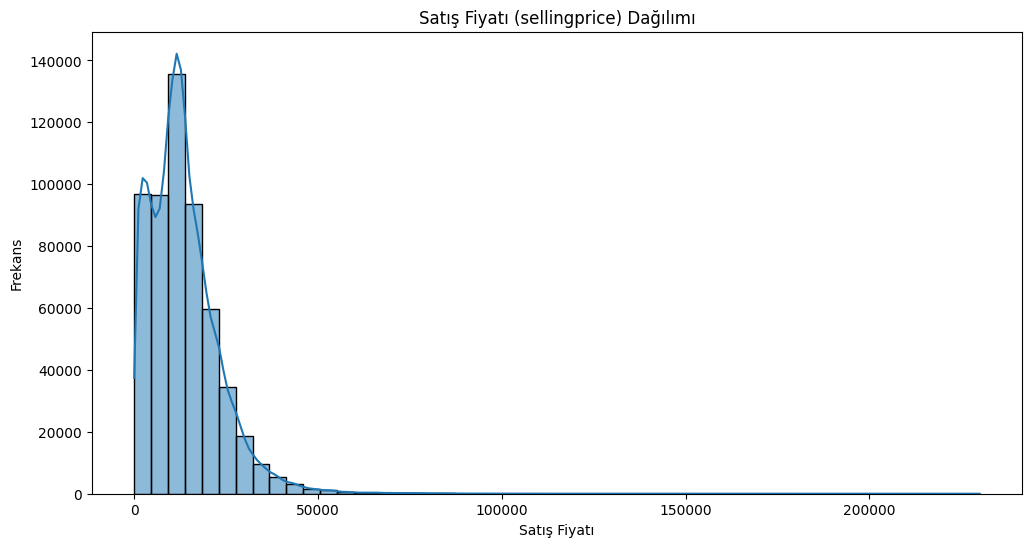

In [10]:
# Hedef değişkenin (sellingprice) dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['sellingprice'], kde=True, bins=50)
plt.title('Satış Fiyatı (sellingprice) Dağılımı')
plt.xlabel('Satış Fiyatı')
plt.ylabel('Frekans')
plt.show()

## Veri Ön İşleme

### Gereksiz Sütunların Kaldırılması


In [11]:
columns_to_drop = ['vin', 'state', 'seller', 'mmr']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [12]:
df.head()

,year,make,model,trim,body,transmission,condition,odometer,color,interior,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5.0,16639.0,white,black,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5.0,9393.0,white,beige,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,45.0,1331.0,gray,black,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,41.0,14282.0,white,black,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,43.0,2641.0,gray,black,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


### 'saledate' ve 'year' sütunlarını kullanarak araç yaşı kolonu oluşturma

In [13]:
if 'saledate' in df.columns and 'year' in df.columns:
    # 'saledate' sütununu datetime objesine dönüştür.
    df['saledate_dt'] = pd.to_datetime(df['saledate'], utc=True, errors='coerce')

    df.dropna(subset=['saledate_dt'], inplace=True) # Geçersiz tarihleri at

    df['sale_year'] = df['saledate_dt'].dt.year

    # Araç üretim yılını sayısal yap ve NaN olanları at
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df.dropna(subset=['year'], inplace=True)

    # Yıl sütunlarını integer yap
    df['year'] = df['year'].round().astype(int)
    df['sale_year'] = df['sale_year'].astype(int)

    # Araç yaşını hesapla
    df['vehicle_age'] = df['sale_year'] - df['year']

    # Sadece 30 yaşından küçük araçlar
    df = df[df['vehicle_age'] <= 30]

    # Negatif araç yaşlarını 0 yap
    negative_age_mask = df['vehicle_age'] < 0
    if negative_age_mask.any():
      df.loc[negative_age_mask, 'vehicle_age'] = 0

    # Kullanılan ara sütunları kaldır
    df.drop(columns=['saledate', 'saledate_dt'], inplace=True, errors='ignore')

else:
    print("\n'saledate' veya 'year' sütunu veri setinde bulunamadı. 'vehicle_age' oluşturulamadı.")

In [14]:
df.head()

,year,make,model,trim,body,transmission,condition,odometer,color,interior,sellingprice,sale_year,vehicle_age
0,2015,Kia,Sorento,LX,SUV,automatic,5.0,16639.0,white,black,21500.0,2014,0
1,2015,Kia,Sorento,LX,SUV,automatic,5.0,9393.0,white,beige,21500.0,2014,0
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,45.0,1331.0,gray,black,30000.0,2015,1
3,2015,Volvo,S60,T5,Sedan,automatic,41.0,14282.0,white,black,27750.0,2015,0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,43.0,2641.0,gray,black,67000.0,2014,0


### Eksik Değerlerin Silinmesi

In [15]:
rows_before = df.shape[0]
df.dropna(inplace=True)
rows_after = df.shape[0]

print(f"\nEksik değer içeren satırlar silindi. Önce: {rows_before}, Sonra: {rows_after}, Silinen: {rows_before - rows_after}")
print("\nEksik Değer Sayıları:\n", df.isnull().sum())


Eksik değer içeren satırlar silindi. Önce: 558791, Sonra: 472325, Silinen: 86466

Eksik Değer Sayıları:
 year            0
make            0
model           0
trim            0
body            0
transmission    0
condition       0
odometer        0
color           0
interior        0
sellingprice    0
sale_year       0
vehicle_age     0
dtype: int64


### Aykırı Değerlerin Yönetimi

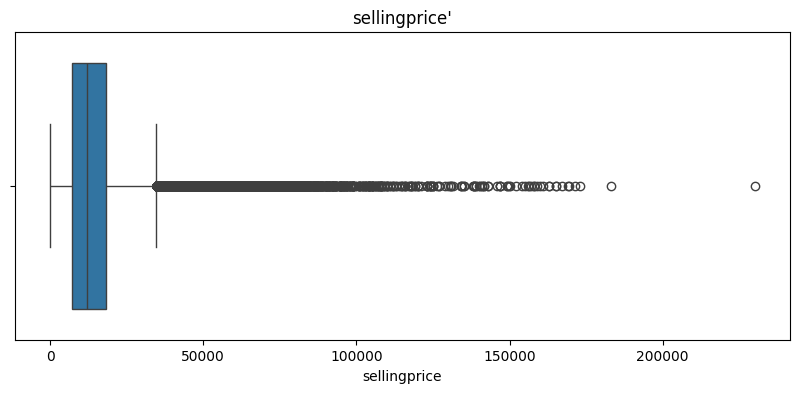

In [16]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['sellingprice'])
plt.title("sellingprice'")
plt.xlabel("sellingprice")
plt.show()

In [17]:
# IQR yöntemi ile aykırı değer temizliği - sellingprice
Q1_price = df['sellingprice'].quantile(0.25)
Q3_price = df['sellingprice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

lower_price = Q1_price - 1.5 * IQR_price
upper_price = Q3_price + 1.5 * IQR_price

df = df[(df['sellingprice'] >= lower_price) & (df['sellingprice'] <= upper_price)]
print(f"'sellingprice' için IQR temelli filtreleme sonrası veri boyutu: {df.shape}")

'sellingprice' için IQR temelli filtreleme sonrası veri boyutu: (458207, 13)


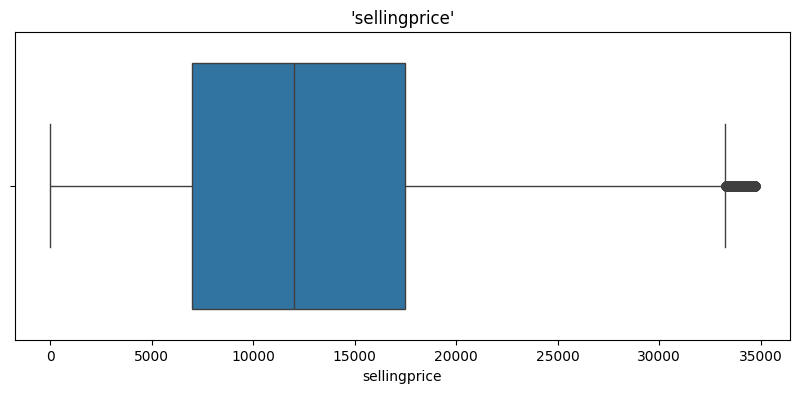

In [18]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['sellingprice'])
plt.title("'sellingprice'")
plt.xlabel("sellingprice")
plt.show()

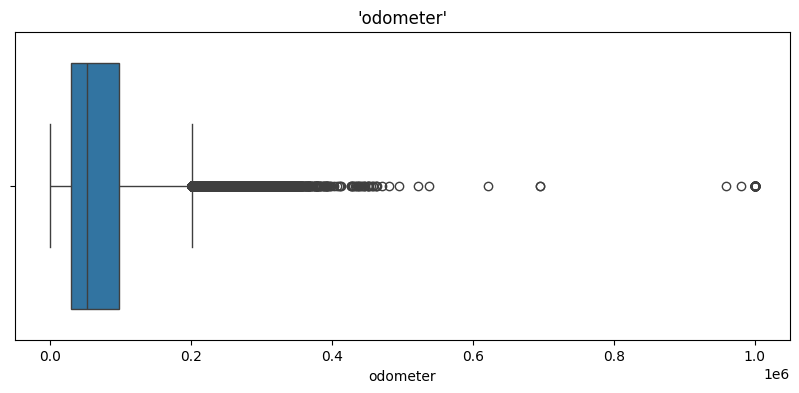

In [19]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['odometer'])
plt.title("'odometer'")
plt.xlabel("odometer")
plt.show()

In [20]:
Q1_odo = df['odometer'].quantile(0.25)
Q3_odo = df['odometer'].quantile(0.75)
IQR_odo = Q3_odo - Q1_odo

lower_odo = Q1_odo - 1.5 * IQR_odo
upper_odo = Q3_odo + 1.5 * IQR_odo

df = df[(df['odometer'] >= lower_odo) & (df['odometer'] <= upper_odo)]
print(f"'odometer' için IQR temelli filtreleme sonrası veri boyutu: {df.shape}")

'odometer' için IQR temelli filtreleme sonrası veri boyutu: (449808, 13)


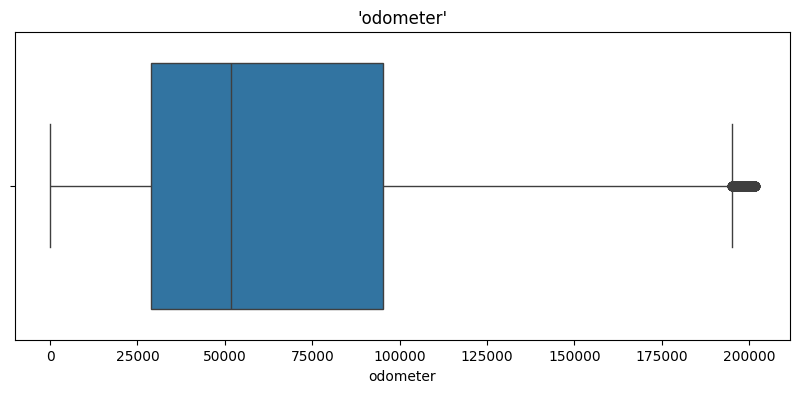

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['odometer'])
plt.title("'odometer'")
plt.xlabel("odometer")
plt.show()

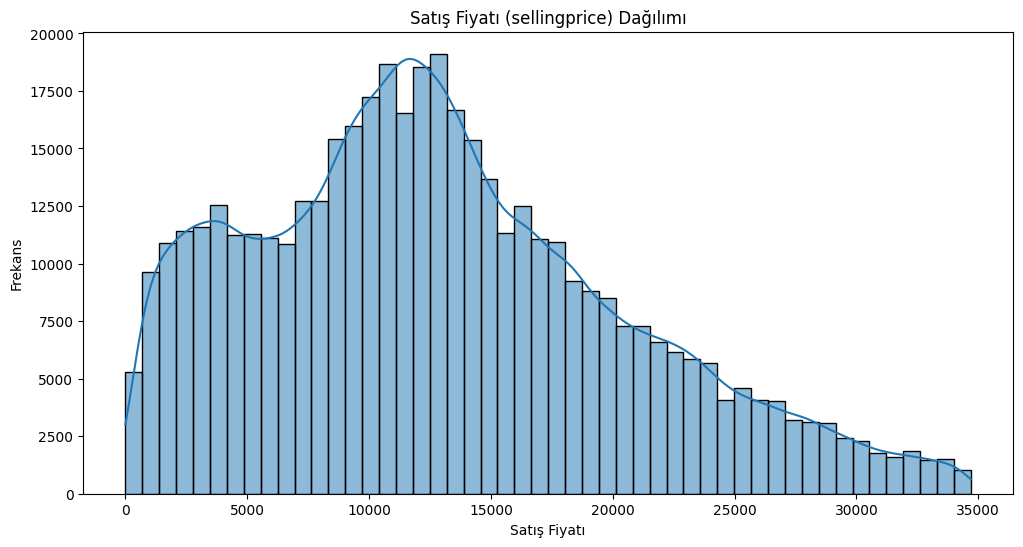

In [22]:
# Hedef değişkenin yeni (sellingprice) dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['sellingprice'], kde=True, bins=50)
plt.title('Satış Fiyatı (sellingprice) Dağılımı')
plt.xlabel('Satış Fiyatı')
plt.ylabel('Frekans')
plt.show()

 ### Kategorik Verilerin İşlenmesi (Encoding) & Yüksek Kardinalite Yönetimi

In [23]:
def reduce_cardinality(df_orig, column_name, threshold_abs=100, new_category_name="Other"):
    df = df_orig.copy()
    counts = df[column_name].value_counts()
    # Eşiğin altındaki kategorileri belirle
    categories_to_group = counts[counts < threshold_abs].index.tolist()

    if categories_to_group:
        print(f"'{column_name}' sütununda {len(categories_to_group)} kategori (frekans < {threshold_abs}) '{new_category_name}' olarak gruplanıyor.")
        df[column_name] = df[column_name].apply(lambda x: new_category_name if x in categories_to_group else x)
    else:
        print(f"'{column_name}' sütununda belirtilen eşiğin altında kategori bulunamadı.")
    return df

In [24]:
categorical_cols_to_process = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']
for col_name in categorical_cols_to_process:
    if col_name in df.columns:
        df[col_name] = df[col_name].astype(str).str.lower().str.strip()

        unique_before = df[col_name].nunique()

        df = reduce_cardinality(df, col_name, threshold_abs=200, new_category_name=f'Other_{col_name}')
        print(f"'{col_name}' benzersiz değer sayısı: {unique_before} -> {df[col_name].nunique()}")
    else:
        print(f"'{col_name}' sütunu bulunamadı, kardinalite azaltma atlandı.")

'make' sütununda 6 kategori (frekans < 200) 'Other_make' olarak gruplanıyor.
'make' benzersiz değer sayısı: 46 -> 41
'model' sütununda 429 kategori (frekans < 200) 'Other_model' olarak gruplanıyor.
'model' benzersiz değer sayısı: 715 -> 287
'trim' sütununda 1164 kategori (frekans < 200) 'Other_trim' olarak gruplanıyor.
'trim' benzersiz değer sayısı: 1383 -> 220
'body' sütununda 20 kategori (frekans < 200) 'Other_body' olarak gruplanıyor.
'body' benzersiz değer sayısı: 43 -> 24
'transmission' sütununda belirtilen eşiğin altında kategori bulunamadı.
'transmission' benzersiz değer sayısı: 2 -> 2
'color' sütununda 3 kategori (frekans < 200) 'Other_color' olarak gruplanıyor.
'color' benzersiz değer sayısı: 20 -> 18
'interior' sütununda 5 kategori (frekans < 200) 'Other_interior' olarak gruplanıyor.
'interior' benzersiz değer sayısı: 17 -> 13


## Hedef değişken ve Özelliklerin Ayrılması

In [25]:
X = df.drop('sellingprice', axis=1)
y = df['sellingprice']

In [26]:
# Sayısal ve Kategorik Sütunların Belirlenmesi (Ön işleme sonrası)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("\nSayısal Sütunlar:", numerical_cols)
print("Kategorik Sütunlar:", categorical_cols)


Sayısal Sütunlar: ['year', 'condition', 'odometer', 'sale_year', 'vehicle_age']
Kategorik Sütunlar: ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']


## Makine Öğrenmesi Pipeline'ı Oluşturma

In [27]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough'
)

In [28]:
# Veriyi Eğitim ve Test Olarak Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (359846, 12), X_test shape: (89962, 12)


## Algoritma Performans Testleri

In [29]:
# Denenecek Modeller (Regresyon)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42, max_iter=50, tol=0.01),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=12, min_samples_split=50, min_samples_leaf=20)
}

results = {}
r2_scores = {}

In [30]:
for name, model in models.items():
    print(f"Training {name}...")
    # Her model için tam pipeline oluştur
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    try:
        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        y_train_eval = y_train
        y_test_eval = y_test


        train_rmse = np.sqrt(mean_squared_error(y_train_eval, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_test))
        train_r2 = r2_score(y_train_eval, y_pred_train)
        test_r2 = r2_score(y_test_eval, y_pred_test)

        results[name] = {'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
                         'Train R2': train_r2, 'Test R2': test_r2}
        r2_scores[name] = test_r2 # Sadece test R2'yi sakla, sıralama için
        print(f"{name} - Test R2: {test_r2:.4f}, Test RMSE: {test_rmse:.2f}\n")

    except Exception as e:
        print(f"Error training {name}: {e}\n")
        results[name] = {'Train RMSE': np.nan, 'Test RMSE': np.nan,
                         'Train R2': np.nan, 'Test R2': np.nan}
        r2_scores[name] = -np.inf


Training Linear Regression...
Linear Regression - Test R2: 0.8692, Test RMSE: 2740.54

Training Ridge Regression...
Ridge Regression - Test R2: 0.8692, Test RMSE: 2741.11

Training Lasso Regression...
Lasso Regression - Test R2: 0.8618, Test RMSE: 2817.47

Training Decision Tree...
Decision Tree - Test R2: 0.7765, Test RMSE: 3582.91



In [31]:
# Sonuçları göster
results_df = pd.DataFrame(results).T.sort_values(by="Test R2", ascending=False)
print("\nModel Performansları:")
print(results_df)


Model Performansları:
                    Train RMSE    Test RMSE  Train R2   Test R2
Linear Regression  2704.639042  2740.535044  0.872092  0.869214
Ridge Regression   2705.955600  2741.109276  0.871968  0.869159
Lasso Regression   2786.481394  2817.467035  0.864234  0.861768
Decision Tree      3539.545881  3582.909016  0.780935  0.776457


Performans kısıtlarından ötürü decision tree sınırlı şekilde kullanılmıştır ve bu durumda en optimal model ridge bulunmuştır. Ridge Regression için hiperparametre optimizasyonu:


In [33]:
# Ridge için Pipeline ve Parametre Grid'i
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', Ridge(random_state=42))])
param_grid_ridge = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000] # Denenecek alpha değerleri
}
grid_search_ridge = GridSearchCV(estimator=pipeline_ridge,
                                 param_grid=param_grid_ridge,
                                 cv=5,
                                 scoring='r2',
                                 n_jobs=-1,
                                 verbose=1)
grid_search_ridge.fit(X_train, y_train)
print(f"\nEn iyi Ridge parametreleri: {grid_search_ridge.best_params_}")
print(f"En iyi Ridge R2 (CV): {grid_search_ridge.best_score_:.4f}")
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_test_ridge = best_ridge_model.predict(X_test)
test_r2_ridge = r2_score(y_test, y_pred_test_ridge)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
print(f"Optimize Edilmiş Ridge - Test R2: {test_r2_ridge:.4f}, Test RMSE: {test_rmse_ridge:.2f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits

En iyi Ridge parametreleri: {'regressor__alpha': 0.01}
En iyi Ridge R2 (CV): 0.8714
Optimize Edilmiş Ridge - Test R2: 0.8692, Test RMSE: 2741.04
